In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load custom evaluation plot functions
from classification_evaluation import plot_roc_curve, plot_pr_curve, plot_calibration_curve, plot_decision_curve
from classification_evaluation import plot_roc_thresholds, plot_pr_thresholds

import lightgbm as lgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [17]:
# Download UCI diabetes datset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Preprocess

In [18]:
train_df, test_df = train_test_split(df)
print(len(train_df), len(test_df))

668 223


In [19]:
## https://www.kaggle.com/shep312/applying-lightgbm-to-titanic-dataset

# Not sure passenger ID is useful as a feature, but need to save it from the test set for the submission
test_passenger_ids = test_df.pop('PassengerId')
train_df.drop(['PassengerId'], axis=1, inplace=True)

# 'Embarked' is stored as letters, so fit a label encoder to the train set to use in the loop
embarked_encoder = LabelEncoder()
embarked_encoder.fit(train_df['Embarked'].fillna('Null'))

# Dataframes to work on
df_list = [train_df, test_df]

for df in df_list:    
    
    # Record anyone travelling alone
    df['Alone'] = (df['SibSp'] == 0) & (df['Parch'] == 0)
    
    # Transform 'Embarked'
    df['Embarked'].fillna('Null', inplace=True)
    df['Embarked'] = embarked_encoder.transform(df['Embarked'])
    
    # Transform 'Sex'
    df.loc[df['Sex'] == 'female','Sex'] = 0
    df.loc[df['Sex'] == 'male','Sex'] = 1
    df['Sex'] = df['Sex'].astype('int8')
    
    # Drop features that seem unusable. Save passenger ids if test
    df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    

# Separate the label
y = train_df.pop('Survived')

# Take a hold out set randomly
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

# Create an LGBM dataset for training
categorical_features = ['Alone', 'Sex', 'Pclass', 'Embarked']
train_data = lgbm.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

# Create an LGBM dataset from the test
test_data = lgbm.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

# Finally, create a dataset for the FULL training data to give us maximum amount of data to train on after 
# performance has been calibrate
final_train_set = lgbm.Dataset(data=train_df, label=y, 
                               categorical_feature=categorical_features, free_raw_data=False)

C:\Users\HR\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Fit model

In [20]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
              }

evaluation_results = {}
clf = lgbm.train(train_set=train_data,
                 params=lgbm_params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 num_boost_round=500,
                 early_stopping_rounds=100,
                 verbose_eval=20
                )
optimum_boost_rounds = clf.best_iteration

C:\Users\HR\Anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\HR\Anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[20]	Train's binary_logloss: 0.496117	Test's binary_logloss: 0.549247
[40]	Train's binary_logloss: 0.427085	Test's binary_logloss: 0.479277
[60]	Train's binary_logloss: 0.4086	Test's binary_logloss: 0.454413
[80]	Train's binary_logloss: 0.388881	Test's binary_logloss: 0.435652
[100]	Train's binary_logloss: 0.381981	Test's binary_logloss: 0.43485
[120]	Train's binary_logloss: 0.370081	Test's binary_logloss: 0.427289
[140]	Train's binary_logloss: 0.356777	Test's binary_logloss: 0.420787
[160]	Train's binary_logloss: 0.360921	Test's binary_logloss: 0.420047
[180]	Train's binary_logloss: 0.342137	Test's binary_logloss: 0.411068
[200]	Train's binary_logloss: 0.324671	Test's binary_logloss: 0.406657
[220]	Train's binary_logloss: 0.316781	Test's binary_logloss: 0.409001
[240]	Train's binary_logloss: 0.30388	Test's binary_logloss: 0.410378
[260]	Train's binary_logloss: 0.296275	Test's binary_logloss: 0.410815
[280]	Train's binary_l

In [27]:
y_pred = clf.predict(X_test).reshape(-1,1)
y_true = y_test

# Single plots

## ROC

 Simple plot

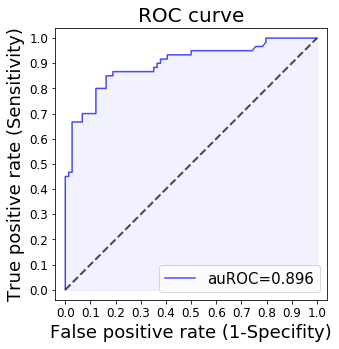

In [28]:
plot_roc_curve(y_true, y_pred, fill=True)

## Precision Recall curve

 Simple plot

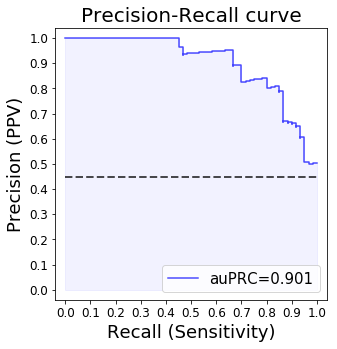

In [29]:
plot_pr_curve(y_true, y_pred, fill=True)

## Calibration curves

Plot with bins given by absolute bins of probabilites, i.e.: [0,10], [10,20], .... [90,100]

Plot with histogram as seperate subplot

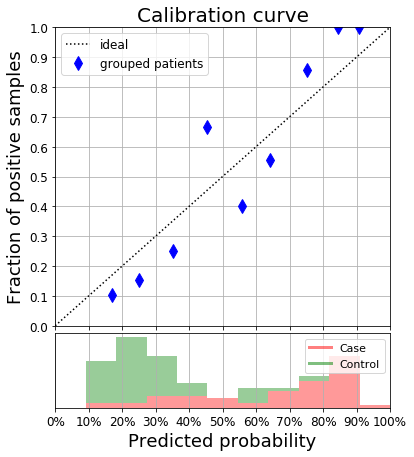

In [30]:
plot_calibration_curve(y_true, y_pred, n_bins=10, bins_by_percentile=False, plot_lowess=False, as_subplot=True);

Plot with bins given by deciles of predicted probablilites

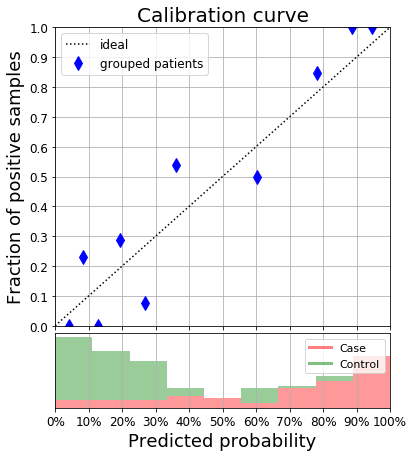

In [31]:
plot_calibration_curve(y_true, y_pred, n_bins=10, bins_by_percentile=True,
                       normalize=True, plot_lowess=False, as_subplot=True);

Plot with histogram on same plot

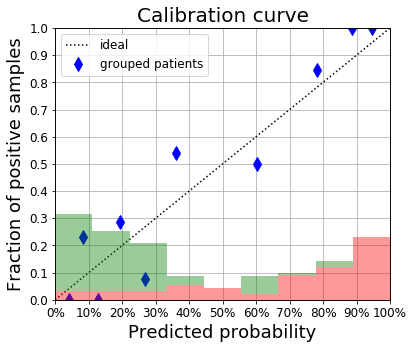

In [34]:
plot_calibration_curve(y_true, y_pred, n_bins=10, bins_by_percentile=True,
                       normalize=True, plot_lowess=False, as_subplot=False);

## Decision curves

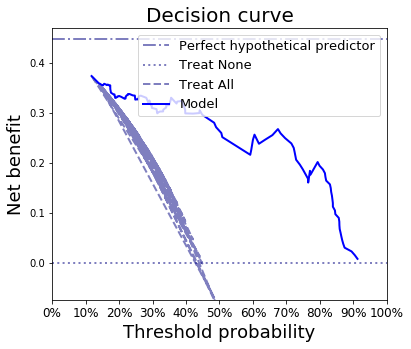

In [36]:
plot_decision_curve(y_true, y_pred, label='Model')